## **ONLINE stage**

#### LOAD LIBRARIES

In [81]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import json

import sys
from fom import full_order_solution

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2891/3495357324.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2891/3495357324.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


#### MATRICES LOADING

In [82]:
# Apri il file in modalità lettura
with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]   #N_epsilon x N_epsilon
    FF_RB = hf['FF_RB'][:]   #N_epsilon x 1
    KK_RB = hf['KK_RB'][:]   #N_D+N_D x N_epsilon x N_epsilon
    AA_RB = hf['AA_RB'][:]   #N_epsilon
    ZZ_CO = hf['ZZ_CO'][:]   #N_D
    II_CO = hf['II_CO'][:]   #N_D x N_D

### OF CASE

In [84]:
# Lettura dei parametri dal file JSON
with open("../0. full order/OF parameters.json", "r") as json_file:
    parameters = json.load(json_file)
T_BC = parameters["T_BC"]  
FISSION_RATE = parameters["FISSION_RATE"]                   # [fiss/s]
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 # [at/fiss]
FUEL_DENSITY = parameters["FUEL_DENSITY"]                   # [kg/m^3]
FUEL_SPECIFIC_HEAT = parameters["FUEL_SPECIFIC_HEAT"]       # [J/(kg K)]
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]  # [W/(m K)]
TIME_FINAL = 1.00E+07
TIME_DELTA = 1.00E+04

In [ ]:
full_order_solution() 

#### SELECTION OF THE FULL ORDER PARAMETERS 

In [44]:
FISSION_ENERGY = 3.215E-11                      #[J/fissions]
POWER_DENSITY = FISSION_ENERGY * FISSION_RATE   #q''' [W/m^3]
FISSION_HEAT = FISSION_ENERGY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)    #[K/fissions] = Energia di fissione/(rho Cp)
SOURCE_T = POWER_DENSITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)   #[K/s] = q'''/(rho Cp) 
SOURCE_C = FISSION_RATE * FISSION_YIELD                      #[atm / (m^3 s)]
ALPHA_T = FUEL_THERMAL_CONDUCTIVITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)  # [m^2 / s]        # = k/(rho Cp)

print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "fiss/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m")
print("The selected Fission Yield is", FISSION_YIELD, "at/fiss")
print("The selected Power Density q''' is", POWER_DENSITY, "W/m^3")
print("The selected Fuel Density is",FUEL_DENSITY, "kg/m^3")
print("The selected Fuel Specific Heat Cp is", FUEL_SPECIFIC_HEAT, "J/(kg K)")
print("The selected Fuel Thermal Conductivity k is", FUEL_THERMAL_CONDUCTIVITY, "W/(m K)\n")

The selected Boundary Temperature is 2000 K
The selected Fission Rate is 3e+19 fiss/s
The selected Grain Length is 0.001 m
The selected Grain Radius is 1e-05 m
The selected Fission Yield is 0.24 at/fiss
The selected Power Density q''' is 964500000.0 W/m^3
The selected Fuel Density is 11040 kg/m^3
The selected Fuel Specific Heat Cp is 400 J/(kg K)
The selected Fuel Thermal Conductivity k is 2.208 W/(m K)



#### CONSTRUCTION OF THE LHS AND RHS

In [45]:
TT = T_BC + (SOURCE_T * LENGTH**2 / ALPHA_T) * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 2.949513e-13 * np.exp(-20487.36244 / (TT));
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

#### FORWARD EULER

In [46]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1001))
for ii in range(1,1001):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

6.540161989383457e+22
1.2768468974365381e+23
1.8765015188828967e+23
2.457077810988235e+23
3.021151619112645e+23
3.570531402685829e+23
4.1065762245872596e+23
4.630355844311561e+23
5.142740929563231e+23
5.6444581809109915e+23
6.136126179534592e+23
6.618279862450492e+23
7.09138788981375e+23
7.55586535748662e+23
8.01208334390081e+23
8.460376235992854e+23
8.901047455974834e+23
9.334374010762642e+23
9.760610157712273e+23
1.0179990395690361e+24
1.0592731933203828e+24
1.0999036745650229e+24
1.1399093305756374e+24
1.1793078051167106e+24
1.218115663847731e+24
1.2563485022142476e+24
1.294021038856145e+24
1.3311471969444566e+24
1.3677401753837552e+24
1.4038125114493108e+24
1.4393761361402498e+24
1.474442423302465e+24
1.5090222333938858e+24
1.5431259526192107e+24
1.5767635280437288e+24
1.609944499200041e+24
1.6426780266231177e+24
1.674972917684549e+24
1.7068376500432286e+24
1.7382803929851197e+24
1.7693090268874236e+24
1.7999311610109896e+24
1.830154149798292e+24
1.859985107831753e+24
1.88943092358

#### COMPARISON WITH THE FULL ORDER MODEL

Errore massimo in python: 1.798E-03%
Errore massimo in sciantix: 1.789E-03%


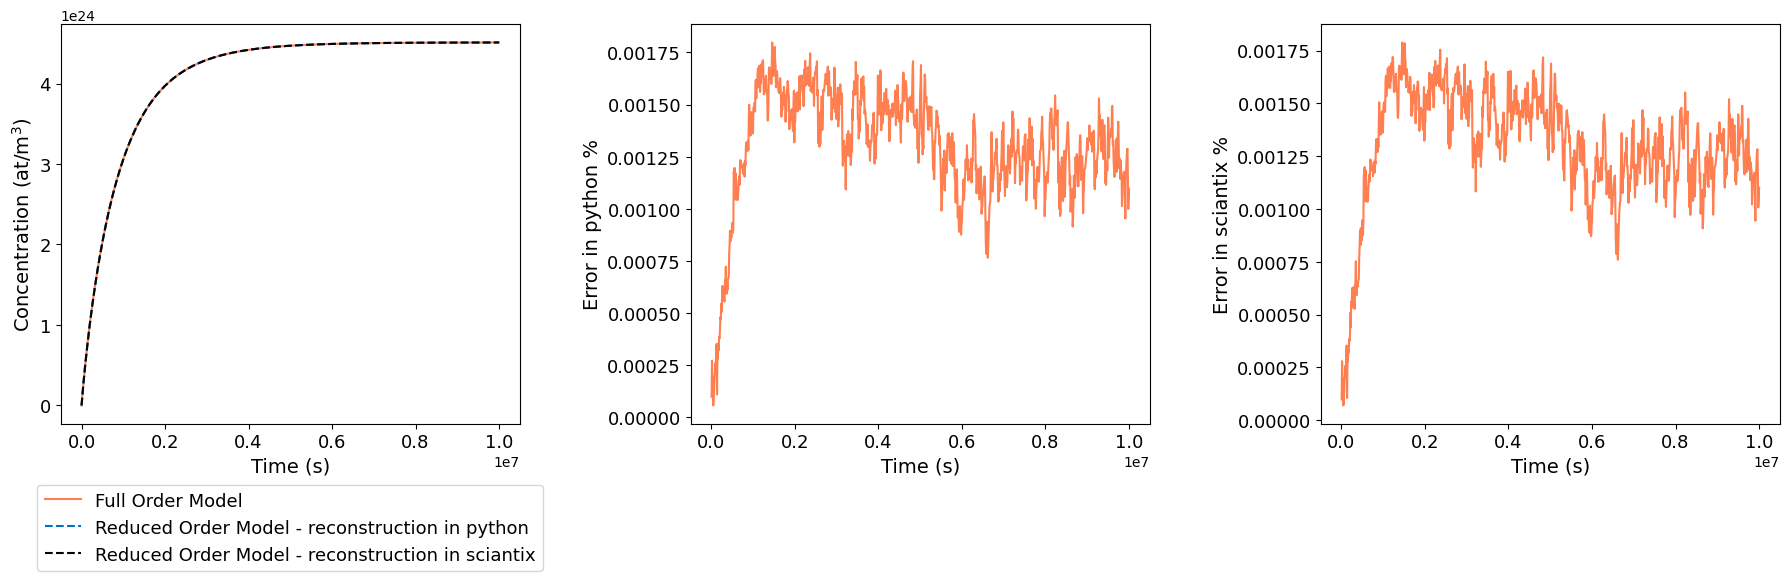

In [48]:
full_order= pd.read_csv('FOM_OF.csv')
sciantix =  pd.read_table("/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/trial/reference case/output.txt")

#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - reconstructed_solution[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in python: {error:.3E}%")
#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - sciantix['Xe in grain (at/m3)'].iloc[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in sciantix: {error:.3E}%")

error_python = (np.abs(full_order.iloc[:, 1] - reconstructed_solution) / full_order.iloc[:, 1])*100
error_python_max = np.max(error_python)
print(f"Errore massimo in python: {error_python_max:.3E}%")

error_sciantix = (np.abs(full_order.iloc[:, 1] - sciantix['Xe in grain (at/m3)']) / full_order.iloc[:, 1]) * 100
error_sciantix_max = np.max(error_sciantix)
print(f"Errore massimo in sciantix: {error_sciantix_max:.3E}%")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.plot(np.linspace(0, 1e7, 1001), full_order.iloc[:, 1], label = 'Full Order Model', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),reconstructed_solution , '--',label = 'Reduced Order Model - reconstruction in python', color='#0072bd', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),sciantix['Xe in grain (at/m3)'], '--', label='Reduced Order Model - reconstruction in sciantix', color='#050402', linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel('Concentration (at/m$^3$)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=1, fontsize=13)

ax2.plot(np.linspace(0, 1e7, 1001), error_python, color='#FF7F50', linewidth=1.5)
ax2.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis='x', labelsize=13)
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel('Time (s)',fontsize=14)
ax2.set_ylabel('Error in python %',fontsize=14)

ax3.plot(np.linspace(0, 1e7, 1001), error_sciantix, color='#FF7F50', linewidth=1.5)
ax3.tick_params(axis="y", labelsize=13)
ax3.tick_params(axis='x', labelsize=13)
ax3.ticklabel_format(useOffset=False)
ax3.set_xlabel('Time (s)',fontsize=14)
ax3.set_ylabel('Error in sciantix %',fontsize=14)

plt.tight_layout()

### WORST RECONSTRUCTED PARAMETERS CASE

In [60]:
# Lettura dei parametri dal file JSON
with open("../2. DEIM-POD/worst reconstructed parameters.json", "r") as json_file:
    parameters = json.load(json_file)

T_BC = parameters["T_BC"]  
FISSION_RATE = parameters["FISSION_RATE"]                   # [fiss/s]
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 # [at/fiss]
FUEL_DENSITY = parameters["FUEL_DENSITY"]                   # [kg/m^3]
FUEL_SPECIFIC_HEAT = parameters["FUEL_SPECIFIC_HEAT"]       # [J/(kg K)]
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]  # [W/(m K)]
TIME_FINAL = 1.00E+07
TIME_DELTA = 1.00E+04



In [ ]:
full_order_solution(RADIUS=RADIUS, LENGTH=LENGTH, FISSION_RATE=FISSION_RATE, FISSION_YIELD=FISSION_YIELD, FUEL_DENSITY=FUEL_DENSITY, FUEL_SPECIFIC_HEAT=FUEL_SPECIFIC_HEAT, T_BC=T_BC, FUEL_THERMAL_CONDUCTIVITY=FUEL_THERMAL_CONDUCTIVITY, TIME_FINAL = TIME_FINAL, TIME_DELTA = TIME_DELTA)

In [61]:
FISSION_ENERGY = 3.215E-11                      #[J/fissions]
POWER_DENSITY = FISSION_ENERGY * FISSION_RATE   #q''' [W/m^3]
FISSION_HEAT = FISSION_ENERGY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)    #[K/fissions] = Energia di fissione/(rho Cp)
SOURCE_T = POWER_DENSITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)   #[K/s] = q'''/(rho Cp) 
SOURCE_C = FISSION_RATE * FISSION_YIELD                      #[atm / (m^3 s)]
ALPHA_T = FUEL_THERMAL_CONDUCTIVITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)  # [m^2 / s]        # = k/(rho Cp)

print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "fiss/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m")
print("The selected Fission Yield is", FISSION_YIELD, "at/fiss")
print("The selected Power Density q''' is", POWER_DENSITY, "W/m^3")
print("The selected Fuel Density is",FUEL_DENSITY, "kg/m^3")
print("The selected Fuel Specific Heat Cp is", FUEL_SPECIFIC_HEAT, "J/(kg K)")
print("The selected Fuel Thermal Conductivity k is", FUEL_THERMAL_CONDUCTIVITY, "W/(m K)\n")

The selected Boundary Temperature is 2042.6504453105797 K
The selected Fission Rate is 2.7074489294577676e+19 fiss/s
The selected Grain Length is 0.0008331856977437343 m
The selected Grain Radius is 1.2036678228038856e-05 m
The selected Fission Yield is 0.03257499825229173 at/fiss
The selected Power Density q''' is 870444830.8206723 W/m^3
The selected Fuel Density is 10213.029435076762 kg/m^3
The selected Fuel Specific Heat Cp is 279.13718973020485 J/(kg K)
The selected Fuel Thermal Conductivity k is 0.955005884878078 W/(m K)



In [62]:
TT = T_BC + (SOURCE_T * LENGTH**2 / ALPHA_T) * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 2.949513e-13 * np.exp(-20487.36244 / (TT));
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

In [63]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1001))
for ii in range(1,1001):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

7.974035069992674e+21
1.5548191915962664e+22
2.2825607588612326e+22
2.9859029784424213e+22
3.6681605937878224e+22
4.331659897738206e+22
4.978149231526619e+22
5.6090052160085e+22
6.225348663524586e+22
6.828115336322896e+22
7.418101973102343e+22
7.995997737104529e+22
8.562406546941781e+22
9.117863429942437e+22
9.662846805671046e+22
1.019778791196415e+23
1.0723078172608062e+23
1.123907504950244e+23
1.174610675751288e+23
1.2244476111309812e+23
1.2734463699643658e+23
1.3216330531347836e+23
1.369032026124533e+23
1.4156661078203326e+23
1.4615567318673037e+23
1.5067240855072028e+23
1.551187229789259e+23
1.5949642042479554e+23
1.6380721185331673e+23
1.6805272330064157e+23
1.7223450299477546e+23
1.7635402767265504e+23
1.8041270820572114e+23
1.8441189462747882e+23
1.8835288064147713e+23
1.9223690767587982e+23
1.9606516854075827e+23
1.998388107359525e+23
2.035589394504903e+23
2.0722662028881903e+23
2.10842881754326e+23
2.1440871751657083e+23
2.1792508848525426e+23
2.2139292471103577e+23
2.24813127

Errore massimo in python: 4.582E-03%
Errore massimo in sciantix: 4.573E-03%


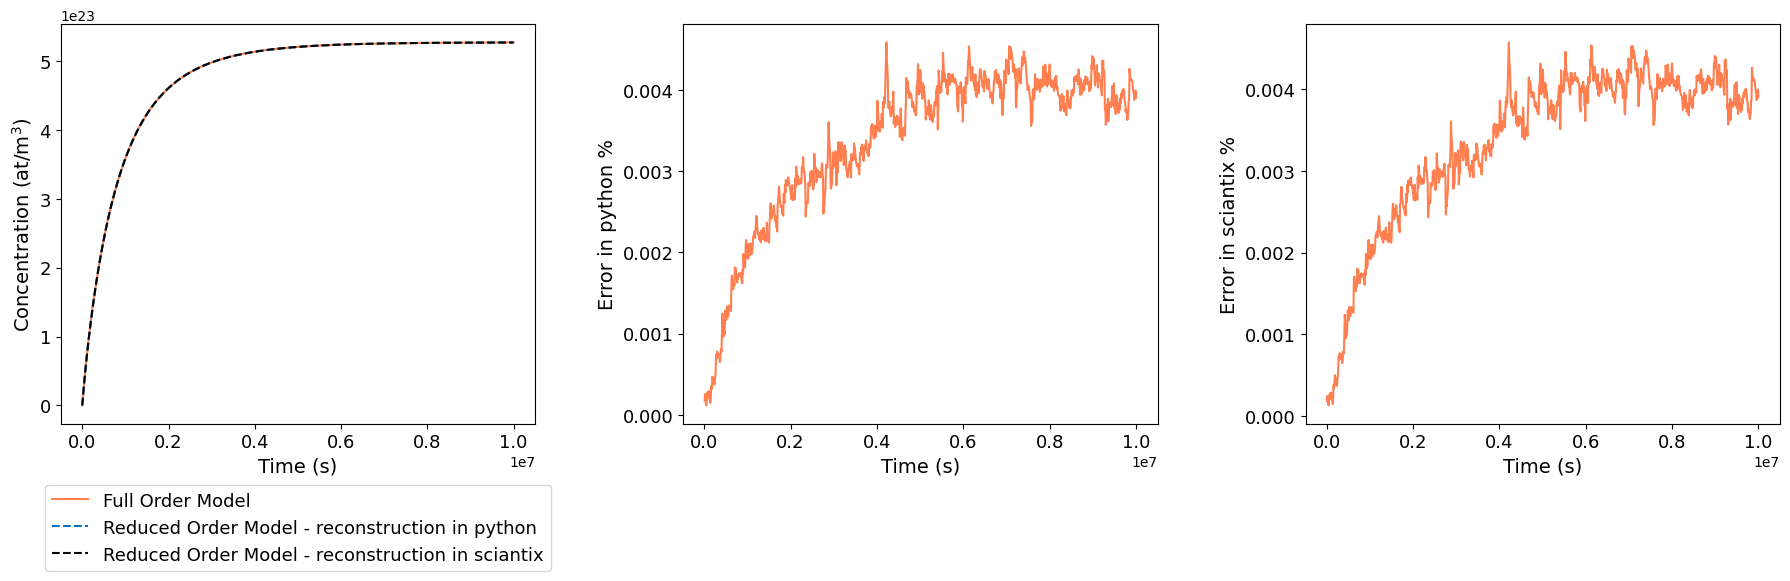

In [64]:
full_order= pd.read_csv('FOM.csv')
sciantix =  pd.read_table("/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/trial/worst reconstructed parameters case/output.txt")
 
#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - reconstructed_solution[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in python: {error:.3E}%")
#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - sciantix['Xe in grain (at/m3)'].iloc[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in sciantix: {error:.3E}%")

error_python = (np.abs(full_order.iloc[:, 1] - reconstructed_solution) / full_order.iloc[:, 1])*100
error_python_max = np.max(error_python)
print(f"Errore massimo in python: {error_python_max:.3E}%")

error_sciantix = (np.abs(full_order.iloc[:, 1] - sciantix['Xe in grain (at/m3)']) / full_order.iloc[:, 1]) * 100
error_sciantix_max = np.max(error_sciantix)
print(f"Errore massimo in sciantix: {error_sciantix_max:.3E}%")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.plot(np.linspace(0, 1e7, 1001), full_order.iloc[:, 1], label = 'Full Order Model', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),reconstructed_solution , '--',label = 'Reduced Order Model - reconstruction in python', color='#0072bd', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),sciantix['Xe in grain (at/m3)'], '--', label='Reduced Order Model - reconstruction in sciantix', color='#050402', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel('Concentration (at/m$^3$)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=1, fontsize=13)

ax2.plot(np.linspace(0, 1e7, 1001), error_python, color='#FF7F50', linewidth=1.5)
ax2.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis='x', labelsize=13)
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel('Time (s)',fontsize=14)
ax2.set_ylabel('Error in python %',fontsize=14)

ax3.plot(np.linspace(0, 1e7, 1001), error_sciantix, color='#FF7F50', linewidth=1.5)
ax3.tick_params(axis="y", labelsize=13)
ax3.tick_params(axis='x', labelsize=13)
ax3.ticklabel_format(useOffset=False)
ax3.set_xlabel('Time (s)',fontsize=14)
ax3.set_ylabel('Error in sciantix %',fontsize=14)

plt.tight_layout()

### Out of range

In [85]:
T_BC = 2600 
FISSION_RATE = 6e19                   # [fiss/s]
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = 1                 # [at/fiss]
FUEL_DENSITY = parameters["FUEL_DENSITY"]                   # [kg/m^3]
FUEL_SPECIFIC_HEAT = parameters["FUEL_SPECIFIC_HEAT"]       # [J/(kg K)]
FUEL_THERMAL_CONDUCTIVITY = 10  # [W/(m K)]
TIME_FINAL = 1.00E+07
TIME_DELTA = 1.00E+04

In [86]:
full_order_solution(RADIUS=RADIUS, LENGTH=LENGTH, FISSION_RATE=FISSION_RATE, FISSION_YIELD=FISSION_YIELD, FUEL_DENSITY=FUEL_DENSITY, FUEL_SPECIFIC_HEAT=FUEL_SPECIFIC_HEAT, T_BC=T_BC, FUEL_THERMAL_CONDUCTIVITY=FUEL_THERMAL_CONDUCTIVITY, TIME_FINAL = TIME_FINAL, TIME_DELTA = TIME_DELTA)

Current time: 0.0 s
Average dC: 0.0 atm/m^3

Current time: 10000.0 s
Average dC: 4.6853197348316544e+23 atm/m^3

Current time: 20000.0 s
Average dC: 8.760845498073556e+23 atm/m^3

Current time: 30000.0 s
Average dC: 1.2400912231779743e+24 atm/m^3

Current time: 40000.0 s
Average dC: 1.5693654148937845e+24 atm/m^3

Current time: 50000.0 s
Average dC: 1.8694638408923294e+24 atm/m^3

Current time: 60000.0 s
Average dC: 2.144317773122208e+24 atm/m^3

Current time: 70000.0 s
Average dC: 2.3969075892991483e+24 atm/m^3

Current time: 80000.0 s
Average dC: 2.6296037889813706e+24 atm/m^3

Current time: 90000.0 s
Average dC: 2.8443603553099764e+24 atm/m^3

Current time: 100000.0 s
Average dC: 3.0428257019823973e+24 atm/m^3

Current time: 110000.0 s
Average dC: 3.2264244031526284e+24 atm/m^3

Current time: 120000.0 s
Average dC: 3.396402061666728e+24 atm/m^3

Current time: 130000.0 s
Average dC: 3.5538694174251023e+24 atm/m^3

Current time: 140000.0 s
Average dC: 3.699807111694458e+24 atm/m^3

Cu

In [87]:
FISSION_ENERGY = 3.215E-11                      #[J/fissions]
POWER_DENSITY = FISSION_ENERGY * FISSION_RATE   #q''' [W/m^3]
FISSION_HEAT = FISSION_ENERGY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)    #[K/fissions] = Energia di fissione/(rho Cp)
SOURCE_T = POWER_DENSITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)   #[K/s] = q'''/(rho Cp) 
SOURCE_C = FISSION_RATE * FISSION_YIELD                      #[atm / (m^3 s)]
ALPHA_T = FUEL_THERMAL_CONDUCTIVITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)  # [m^2 / s]        # = k/(rho Cp)

print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "fiss/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m")
print("The selected Fission Yield is", FISSION_YIELD, "at/fiss")
print("The selected Fuel Thermal Conductivity k is", FUEL_THERMAL_CONDUCTIVITY, "W/(m K)\n")

The selected Boundary Temperature is 2600 K
The selected Fission Rate is 6e+19 fiss/s
The selected Grain Length is 0.001 m
The selected Grain Radius is 1e-05 m
The selected Fission Yield is 1 at/fiss
The selected Fuel Thermal Conductivity k is 10 W/(m K)



In [ ]:
TT = T_BC + (SOURCE_T * LENGTH**2 / ALPHA_T) * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 2.949513e-13 * np.exp(-20487.36244 / (TT));
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

In [89]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1001))
for ii in range(1,1001):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

4.946414537427044e+22
5.498588016577226e+22
5.563717787082717e+22
5.571618885425682e+22
5.572599478201938e+22
5.572723721639281e+22
5.572739764010405e+22
5.572741870937966e+22
5.572742151841273e+22
5.57274218978523e+22
5.5727421949685824e+22
5.5727421956834806e+22
5.5727421957828856e+22
5.5727421957968065e+22
5.572742195798762e+22
5.57274219579904e+22
5.572742195799079e+22
5.572742195799084e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742195799086e+22
5.572742

Errore massimo in python: 9.900E+01%


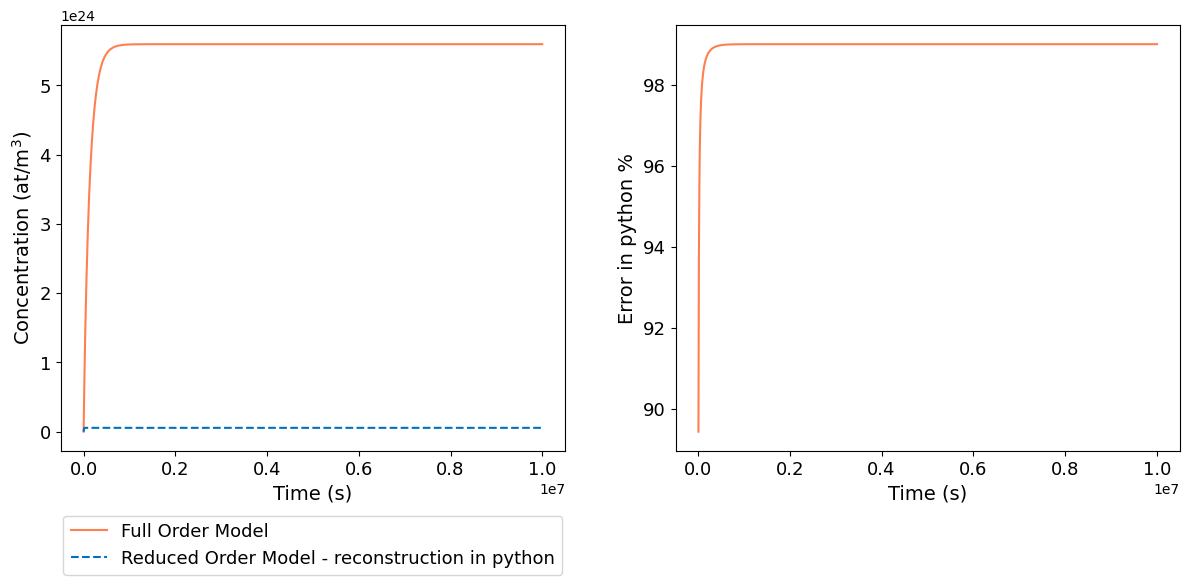

In [90]:
full_order= pd.read_csv('FOM.csv')

error_python = (np.abs(full_order.iloc[:, 1] - reconstructed_solution) / full_order.iloc[:, 1])*100
error_python_max = np.max(error_python)
print(f"Errore massimo in python: {error_python_max:.3E}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(np.linspace(0, 1e7, 1001), full_order.iloc[:, 1], label = 'Full Order Model', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),reconstructed_solution , '--',label = 'Reduced Order Model - reconstruction in python', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel('Concentration (at/m$^3$)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=1, fontsize=13)

ax2.plot(np.linspace(0, 1e7, 1001), error_python, color='#FF7F50', linewidth=1.5)
ax2.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis='x', labelsize=13)
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel('Time (s)',fontsize=14)
ax2.set_ylabel('Error in python %',fontsize=14)

plt.tight_layout()